# SARIMAX on electricity carbon intensity

The website [**electricitymap.org**](https://electricitymap.org) provides real-time data-viz about the origin of electricity consumed around the world. In particular, it provides (sub) hourly view of the CO2-intensity of electricity in grams of CO2-equivalent per kWh electricity consumed (gCO2e/kWh).

<img src='electricitymap.jpg' width = 500>


Carbon intensity flucutates a lot depending on seasons, weather conditions, imports from neighbors countries, etc...

Your goal is to **forecast the hourly carbon intensity of electricity in France up to 48 hours ahead** so as to inform when is best to consumer electricity (e.g. charge electric car)

## Challenge

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load the 50Mo CSV!
df = pd.read_csv('electricity_map_france.csv', parse_dates=['datetime'], index_col=['datetime'])
print(df.shape)
df = df['2016':]
print(df.shape)

(58948, 72)
(32691, 72)


In [ ]:
df.info()

### Your challenge
- Your goal is to predict `carbon_intensity_avg` up to 48h ahead.
- We have 6 years of data at hourly granularity! Enough to make proper `cross_validated` score of `rmpe` over the whole dataset!
- You have access to exogeneous forecast prefixed by `latest_forecasted_` 
    - e.g. you can use `latest_forecasted_price_avg(t+i)` when trying to predict `carbon_intensity_avg(t+i)`
    - for i in [1..48]

### Hints

- You can build a `SARMIAX` model with `exog` features
- Or, you can build your own "traditional" ML-based model, optimizing for the 48h ahead time horizon

## Your turn

In [ ]:
y = df['carbon_intensity_avg']

<AxesSubplot:xlabel='datetime'>

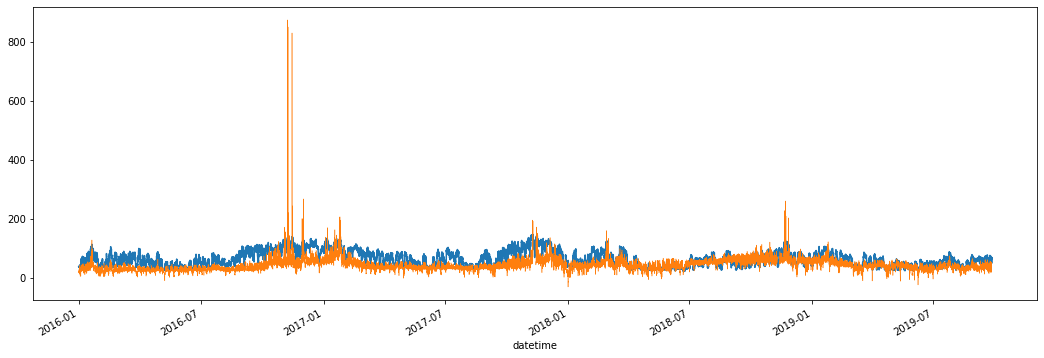

In [ ]:
# %matplotlib widget
y.plot()
df.latest_forecasted_price_avg.plot(linewidth = 0.5,figsize=(18,6))

In [ ]:
df.columns

# Version fb_prophet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install Prophet

In [ ]:
import pandas as pd
from prophet import Prophet

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/fb_prophet/electricity_map_france.csv', parse_dates=['datetime'], index_col=['datetime'])
df = df['2016':]

In [ ]:
df = df['carbon_intensity_avg'].reset_index()
df.columns = ['ds','y']

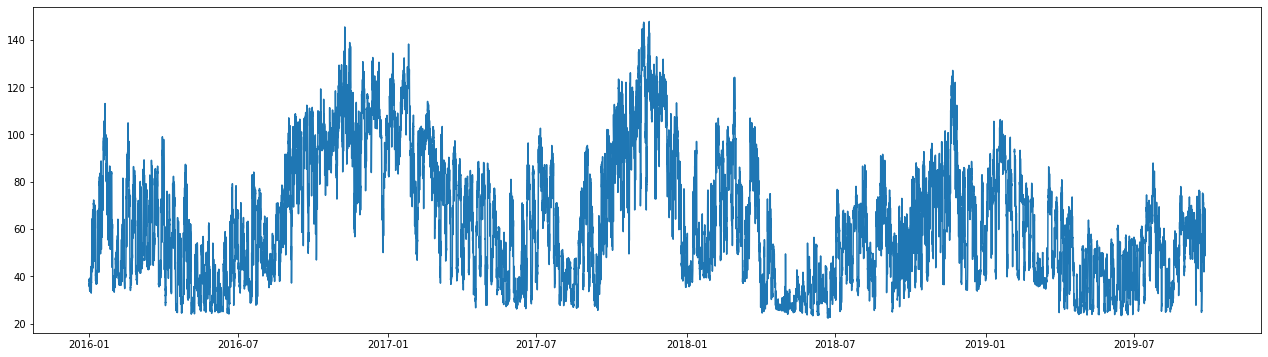

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(22,6))
plt.plot(df.ds,df.y)

In [ ]:
df.ds = df.ds.dt.tz_localize(None)
df.dtypes

ds    datetime64[ns]
y            float64
dtype: object

,ds,y
0,2016-01-01 00:00:00,37.770414
1,2016-01-01 01:00:00,37.918853
2,2016-01-01 02:00:00,38.825366
3,2016-01-01 03:00:00,38.092022
4,2016-01-01 04:00:00,37.066029
...,...,...
32686,2019-09-26 04:00:00,61.804862
32687,2019-09-26 05:00:00,66.438741
32688,2019-09-26 06:00:00,68.071275
32689,2019-09-26 07:00:00,64.317988


In [ ]:
proportion_train = 0.9
cut = int(len(df)*proportion_train)
df_train, df_test = df[:cut],df[cut:]
from fbprophet import Prophet
m = Prophet()
m.fit(df_train)

In [ ]:
df_train

,ds,y
0,2016-01-01 00:00:00,37.770414
1,2016-01-01 01:00:00,37.918853
2,2016-01-01 02:00:00,38.825366
3,2016-01-01 03:00:00,38.092022
4,2016-01-01 04:00:00,37.066029
...,...,...
29416,2019-05-10 16:00:00,54.490951
29417,2019-05-10 17:00:00,53.771582
29418,2019-05-10 18:00:00,53.756859
29419,2019-05-10 19:00:00,53.587849


In [ ]:
future = m.make_future_dataframe(periods=len(df_test),freq='H')
future
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
32686,2019-09-23 22:00:00,64.700004,-17.844617,152.875136
32687,2019-09-23 23:00:00,62.729508,-23.167852,150.288703
32688,2019-09-24 00:00:00,60.316845,-26.706715,151.325906
32689,2019-09-24 01:00:00,58.351536,-32.147545,149.696367
32690,2019-09-24 02:00:00,57.896574,-29.091179,150.907114


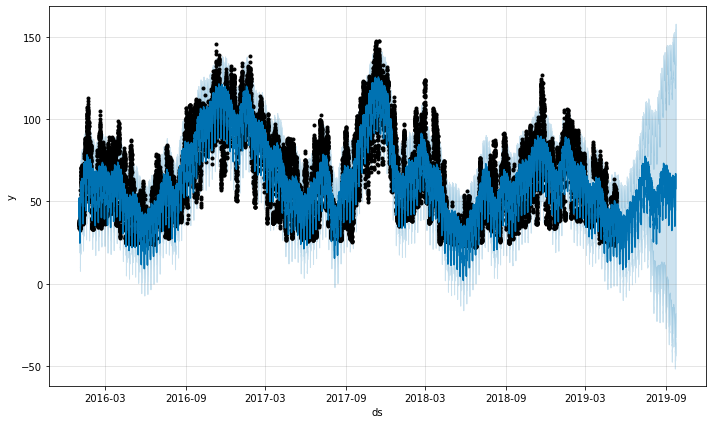

In [ ]:
m.plot(forecast);

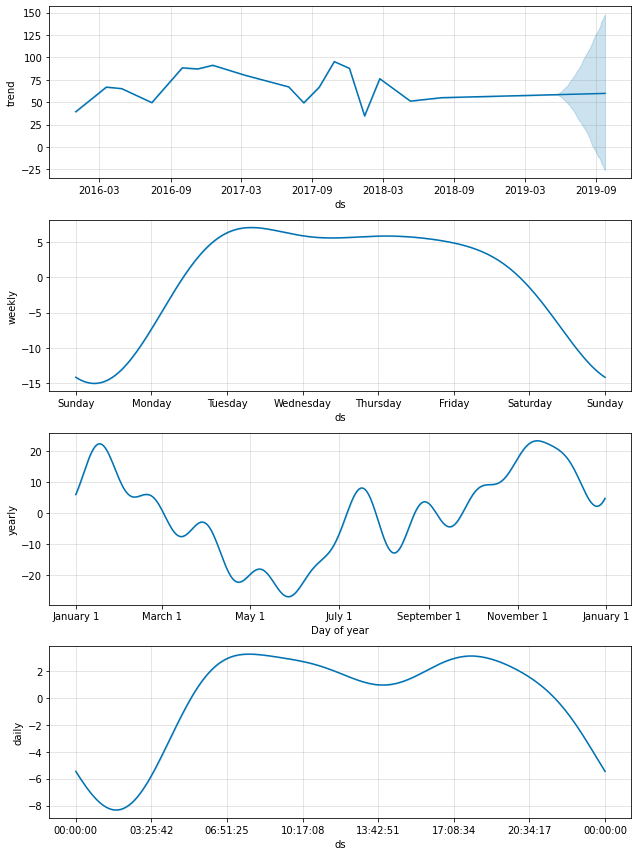

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
df_cv = cross_validation(m, initial='1 Y', period='100 days', horizon = '48 H')

INFO:fbprophet:Making 9 forecasts with cutoffs between 2017-02-27 20:00:00 and 2019-05-08 20:00:00


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-02-27 21:00:00,102.179205,87.342736,117.391723,83.129913,2017-02-27 20:00:00
1,2017-02-27 22:00:00,100.929754,86.378905,115.238165,85.303801,2017-02-27 20:00:00
2,2017-02-27 23:00:00,99.155111,85.039511,112.816829,80.828494,2017-02-27 20:00:00
3,2017-02-28 00:00:00,96.910690,82.172349,111.861224,71.727879,2017-02-27 20:00:00
4,2017-02-28 01:00:00,94.850499,80.212194,110.217526,68.003471,2017-02-27 20:00:00
...,...,...,...,...,...,...
427,2019-05-10 16:00:00,42.425663,23.938104,58.208352,54.490951,2019-05-08 20:00:00
428,2019-05-10 17:00:00,42.819405,25.358630,59.186094,53.771582,2019-05-08 20:00:00
429,2019-05-10 18:00:00,42.708208,25.690297,59.122284,53.756859,2019-05-08 20:00:00
430,2019-05-10 19:00:00,42.012805,24.817527,58.666307,53.587849,2019-05-08 20:00:00


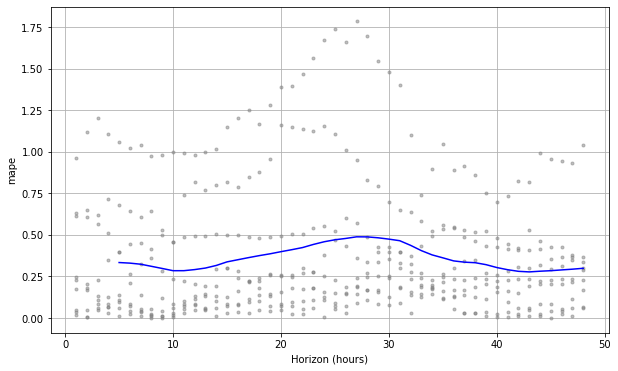

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
df_cv = cross_validation(m, initial='3 Y', period='20 days', horizon = '48 H')
#, parallel="processes"
df_cv

INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-08 20:00:00 and 2019-05-08 20:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, horizon = '48 H')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)